## 4. 작동하기 (1)

In [1]:
import torch
from torch.utils.data.dataloader import DataLoader
from materials.DetectionNet import DetectionNet, create_prior_boxes
from materials.datasets import PascalVOCDataset
import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = PascalVOCDataset(data_folder='./data/VOC', split='TRAIN')
train_dataloader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True, collate_fn=train_dataset.collate_fn)
images, boxes, labels, difficulties = next(iter(train_dataloader))

images = images.to(device)
boxes = [b.to(device) for b in boxes]
labels = [l.to(device) for l in labels]

print('\nImage Batch Shape: {}'.format(images.shape))
print('Boxes Batch Length: {}'.format(len(boxes)))
print('Labels Batch Length: {}'.format(len(labels)))

net = DetectionNet(n_classes=2, unfreeze_keys=['15', 'head', 'bn1'], use_bias=True).to(device)
net.load_state_dict(torch.load('./weapon_test_1.499.pth'))
net.eval()
pred_locs, pred_scores = net(images)

print('\n>>> Location 예측의 Shape: {}'.format(pred_locs.shape))
print('>>> Clsss Score 예측의 Shape: {}'.format(pred_scores.shape))

prior_boxes = create_prior_boxes()
print('\n>>> Prior Boxes의 Shape: {}'.format(prior_boxes.shape))


Image Batch Shape: torch.Size([16, 3, 300, 300])
Boxes Batch Length: 16
Labels Batch Length: 16
Loaded pretrained weights for efficientnet-b0


FileNotFoundError: [Errno 2] No such file or directory: './weapon_test_1.499.pth'

In [ ]:
from torchvision import transforms
from materials.utils import *
from PIL import Image, ImageDraw, ImageFont

# Transforms
resize = transforms.Resize((300, 300))
to_tensor = transforms.ToTensor()
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])


def detect(original_image, model, min_score=0.1, max_overlap=0.5, top_k=5, suppress=None, weapon=True):
    """
    Detect objects in an image with a trained SSD300, and visualize the results.

    :param original_image: image, a PIL Image
    :param min_score: minimum threshold for a detected box to be considered a match for a certain class
    :param max_overlap: maximum overlap two boxes can have so that the one with the lower score is not suppressed via Non-Maximum Suppression (NMS)
    :param top_k: if there are a lot of resulting detection across all classes, keep only the top 'k'
    :param suppress: classes that you know for sure cannot be in the image or you do not want in the image, a list
    :return: annotated image, a PIL Image
    """
    model.eval()
    
    # Transform
    image = normalize(to_tensor(resize(original_image)))

    # Move to default device
    image = image.to(device)

    # Forward prop.
    predicted_locs, predicted_scores = model(image.unsqueeze(0))
    prior_boxes = create_prior_boxes()

    # Detect objects in SSD output
    det_boxes, det_labels, det_scores = model.detect_objects(predicted_locs, predicted_scores, min_score=min_score,
                                                             max_overlap=max_overlap, top_k=top_k)

    # Move detections to the CPU
    det_boxes = det_boxes[0].to('cpu')

    # Transform to original image dimensions
    original_dims = torch.FloatTensor(
        [original_image.width, original_image.height, original_image.width, original_image.height]).unsqueeze(0)
    det_boxes = det_boxes * original_dims

    # Decode class integer labels
    det_labels = [rev_label_map[l] for l in det_labels[0].to('cpu').tolist()]
    
    if weapon:
        det_labels = ['background', 'weapon']

    # If no objects found, the detected labels will be set to ['0.'], i.e. ['background'] in SSD300.detect_objects() in model.py
    if det_labels == ['background']:
        # Just return original image
        return original_image

    # Annotate
    annotated_image = original_image
    draw = ImageDraw.Draw(annotated_image)
    font = ImageFont.load_default()

    # Suppress specific classes, if needed
    for i in range(det_boxes.size(0)):
        if suppress is not None:
            if det_labels[i] in suppress:
                continue

        # Boxes
        box_location = det_boxes[i].tolist()
        if not weapon:
            draw.rectangle(xy=box_location, outline=label_color_map[det_labels[i]])
            draw.rectangle(xy=[l + 1. for l in box_location], outline=label_color_map[
                det_labels[i]]) 
        else:
            draw.rectangle(xy=box_location, outline='black')
            draw.rectangle(xy=[l + 1. for l in box_location], outline='black')  

        # Text

        if not weapon:
            text_size = font.getsize(det_labels[i].upper())
            text_location = [box_location[0] + 2., box_location[1] - text_size[1]]
            textbox_location = [box_location[0], box_location[1] - text_size[1], box_location[0] + text_size[0] + 4.,
                                box_location[1]]
            draw.rectangle(xy=textbox_location, fill=label_color_map[det_labels[i]])
            draw.text(xy=text_location, text=det_labels[i].upper(), fill='white',
                      font=font)
        else:
            text_size = font.getsize('weapon'.upper())
            text_location = [box_location[0] + 2., box_location[1] - text_size[1]]
            textbox_location = [box_location[0], box_location[1] - text_size[1], box_location[0] + text_size[0] + 4.,
                                box_location[1]]
            draw.rectangle(xy=textbox_location, fill='black')
            draw.text(xy=text_location, text='weapon'.upper(), fill='white',
                      font=font)
    del draw

    return annotated_image


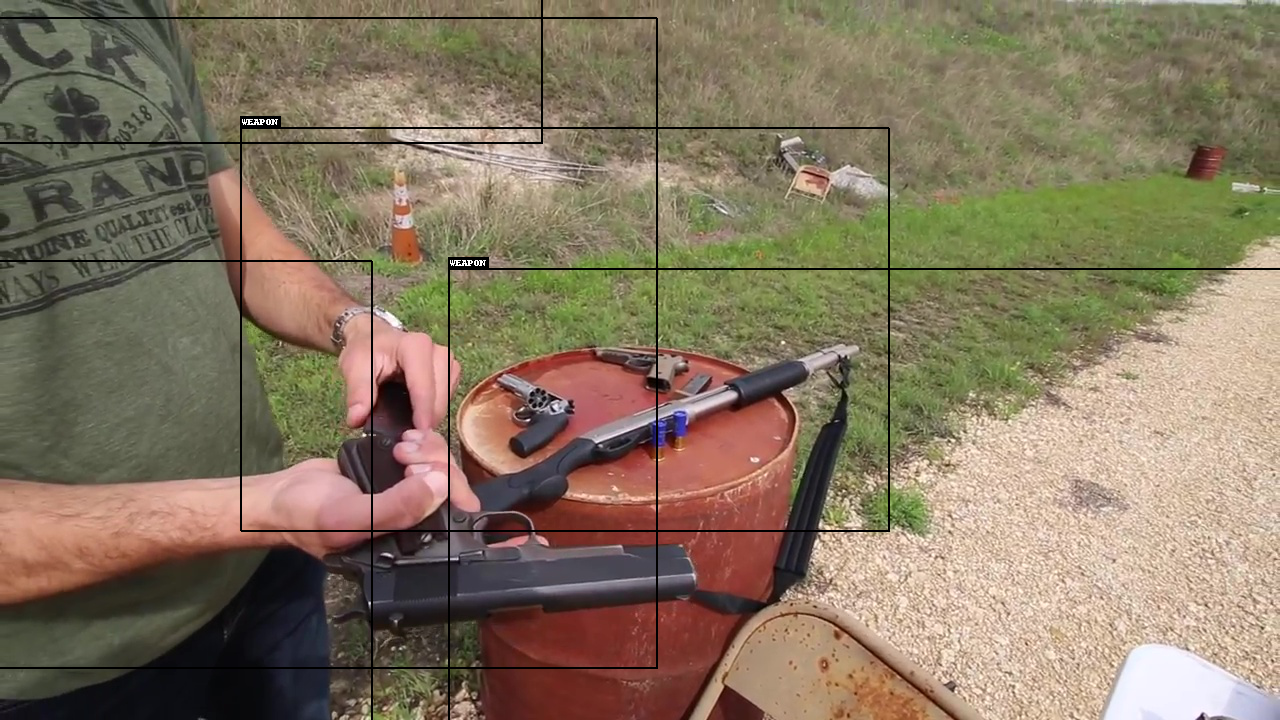

In [8]:
img_path = './data/Weapon/TrainData/PUBGGunsInRealLife!06681.jpg'
original_image = Image.open(img_path, mode='r')
original_image = original_image.convert('RGB')
import warnings
warnings.filterwarnings("ignore")

annotated_image = detect(original_image, net, min_score=0.1, max_overlap=0.5, top_k=5, weapon=True)
annotated_image